the initial data is already cleared according to their length and correlation

In [14]:
%reset -f

import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from minisom import MiniSom

In [15]:
def ability_level_mapper(data, groups=None, col='front', how='naive', n_level=19, invert=True,
                         parameters=None,target_col_name='performance'):
    # the raw data is divided into groups according to its exc_num, ability levels are calculated respectively
    # how: 1 is mapping without any other processing, called 'naive'
    origin = data.copy()
    
    if parameters is not None:
        col, how, n_level, invert, v_max, v_min = parameters
        interval = (v_max- v_min)/n_level
        assert interval!=0, 'zero dividend'
        origin[target_col_name] = (origin[col]-v_min)/interval
        
        origin[target_col_name] = origin[target_col_name].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[target_col_name]+1
        else:
            origin[target_col_name] = origin[target_col_name]+1
        
        return origin, parameters
        
    if groups == None:
        v_max = origin[col].max()
        v_min = origin[col].min()
        
        interval = (v_max- v_min)/n_level
        assert interval!=0, 'zero dividend'
        origin[target_col_name] = (origin[col]-v_min)/interval
        
        origin[target_col_name] = origin[target_col_name].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[target_col_name]+1
        else:
            origin[target_col_name] = origin[target_col_name]+1
        
        parameters = (col, how, n_level, invert, v_max, v_min )
        return origin, parameters
    
    if how == 1 or how=='naive':
        tmp = origin[col]
        for index, group in groups:
            
            v_max = group[col].max()
            v_min = group[col].min()
            
            interval = (v_max-v_min)/n_level
            
            assert interval!=0, 'zero dividend'
            
            origin.loc[index, col] = (origin.loc[index, col]-v_min)/interval
        origin[col] = origin[col].astype(int)
        if invert:
            origin[target_col_name] = n_level-origin[col]+1
            
        else:
            origin[target_col_name] = origin[target_col_name]+1
        origin[col] = tmp
        parameters = (col, how, n_level, invert, v_max, v_min )
        return origin, parameters

def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_resultent_force(df):
    # calc resultent force
    df['resultent_force'] = (df['Fx']-df['Fx.1'])**2+(df['Fy']-df['Fy.1'])**2+(df['Fz']-df['Fz.1'])**2
    df['resultent_force'] = df['resultent_force'].pow(1/2)
    return df

def calc_resultent_force_xy(df):
    # calc resultent force on flat xoy
    df['resultent_force_xy'] = (df['Fx']-df['Fx.1'])**2+(df['Fy']-df['Fy.1'])**2
    df['resultent_force_xy'] = df['resultent_force_xy'].pow(1/2)
    return df


def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']**2
    df['velocity'] = df['velocity'].pow(1/2)
    return df

def calc_velocity_xy(df):
    df['velocity_xy'] = df['Lx']**2 + df['Ly']**2
    df['velocity_xy'] = df['velocity_xy'].pow(1/2)
    return df

def calc_force_velocity_angle_xy(df):
    # calculate angle between walk direction and force direction
    if 'resultent_force_xy' not in df.columns:
        df = calc_resultent_force_xy(df)
        
    if 'velocity_xy' in df.columns: 
        df = calc_velocity_xy(df)
    
    df['angle_fv_xy'] = ((df['Fx']-df['Fx.1'])*df['Lx']+(df['Fy']-df['Fy.1'])*df['Ly'])/  \
        (df['velocity_xy']*df['resultent_force_xy'])
    df['angle_fv_xy'] = df['angle_fv_xy'].apply(np.arccos)
    tmp = df['angle_fv_xy'][df['angle_fv_xy']>np.pi/2]
    tmp -= np.pi
    
    # here is maybe a bug
    df.loc[df.angle_fv_xy>np.pi/2, 'angle_fv_xy'] = tmp
    del tmp
    return df

def calc_torque_xy(df, threshold=0):
    df['torque_xy'] = df['Mz']-df['Mz.1']
    return df

def calc_torque_xy_avg(df, threshold=0, n=100, dropna=True):
    
    if 'torque_xy' not in df.columns:
        df = calc_torque_xy(df)
        
    
    df['torque_xy_avg'] = df['torque_xy'].rolling(n).mean()
        
    if threshold!=0:
        assert threshold>0, 'threshold must be positive'
        df[(df.torque_xy_avg<threshold) & (df.torque_xy_avg>-threshold)] = 1
        df[df.torque_xy_avg<=-threshold] = 0
        df[df.torque_xy_avg>=threshold] = 2
        
    if dropna:
        df = df.dropna()
    return df

def calc_abs_force_velocity_angle_xy(df):
    # calculate absolute angle between walk direction and force direction
    if 'resultent_force_xy' not in df.columns:
        df = calc_resultent_force_xy(df)
        
    if 'velocity_xy' in df.columns: 
        df = calc_velocity_xy(df)
    
    df['abs_angle_fv_xy'] = ((df['Fx']-df['Fx.1'])*df['Lx']+(df['Fy']-df['Fy.1'])*df['Ly'])/  \
        (df['velocity_xy']*df['resultent_force_xy'])
    df['abs_angle_fv_xy'] = abs(df['abs_angle_fv_xy'])
    df['abs_angle_fv_xy'] = df['abs_angle_fv_xy'].apply(np.arccos)
    return df

def calc_torque_turning_freq(df,interval=100, groups=None):
    # calculate the frequency of the changing of the direction of the torque on flat xoy
    result = pd.Series()
    if 'torque_xy' not in df.columns:
        df = calc_torque_xy(df)
    if groups == None:
        groups = df[['uid', 'day', 'exc_num', 'exc_times', 'torque_xy']].   \
            groupby(['uid', 'day', 'exc_num', 'exc_times'])
        
    for index, group in groups:
        # calculate the direction of the changing of the values
        df_tmp = group.reset_index()
        df_tmp['tt_freq'] = df_tmp['torque_xy']
        df_tmp.loc[0, 'tt_freq'] = 0
        tmp1 = df_tmp['torque_xy'][:-1].reset_index(drop=True)
        tmp2 = df_tmp['torque_xy'][1:].reset_index(drop=True)

        tmp3 = tmp2-tmp1
        tmp3.index = tmp3.index+1
        df_tmp.loc[1:, 'tt_freq'] = tmp3

        # delete 0 value, and compare two adjecend value, if the direction changes, then the product is negative.
        tmp3 = df_tmp[df_tmp['tt_freq']!=0][['tt_freq']]
        tmp3 = tmp3.reset_index()
        tmp1 = tmp3['tt_freq'][:-1].reset_index()
        tmp2 = tmp3['tt_freq'][1:].reset_index()
        tmp4 = tmp1*tmp2
        tmp4.index += 1
        tmp3[0, 'tt_freq'] = 0
        tmp3.loc[1:, 'tt_freq'] = tmp4
        tmp3.index = tmp3['index']
        df_tmp.loc[df_tmp.tt_freq!=0, 'tt_freq'] = tmp3['tt_freq']

        # count in interval
        df_tmp.loc[df_tmp.tt_freq>=0, 'tt_freq'] = np.nan
        df_tmp['tt_freq'] = df_tmp['tt_freq'].rolling(interval).count()
        df_tmp.index = df_tmp['index']
        result = pd.concat([result, df_tmp['tt_freq']])
        del tmp1
        del tmp2
        del tmp3
        del tmp4
#     print(result)
    # index aligning
    df['tt_freq'] = result
#     print(all_data[['torque_xy','tt_freq']])
    del result
    return df   

def calc_abs_angle_rotation_velocity_xy(df, groups=None):
    # calculate relative absolute angle rotation of velocity on flat xoy
    
    if 'velocity_xy' not in df.columns:
        df = calc_velocity_xy(df)
        
    result = pd.Series()
    if groups == None:
        groups = df[['uid', 'day', 'exc_num', 'exc_times', 'Lx', 'Ly', 'velocity_xy']].   \
            groupby(['uid', 'day', 'exc_num', 'exc_times'])
        
    for index, group in groups:
        # calculate angle rotation from two adjecend time point
        df_tmp = group.reset_index()
        df_tmp['v_rotation'] = 0
        tmp1 = df_tmp.loc[0:len(df_tmp)-2, ['Lx', 'Ly', 'velocity_xy']].reset_index(drop=True)
        tmp2 = df_tmp.loc[1:, ['Lx', 'Ly', 'velocity_xy']].reset_index(drop=True)
    
        tmp3 = (tmp1['Lx']*tmp2['Lx']+tmp1['Ly']*tmp2['Ly'])/  \
        (tmp1['velocity_xy']*tmp2['velocity_xy'])
#         tmp3 = tmp3.fillna(0)
#         print(tmp3)
        tmp3 = tmp3.apply(np.arccos)
#         print(tmp3)
        tmp3.index += 1
        df_tmp.loc[1:, 'v_rotation'] = tmp3
        df_tmp.loc[df_tmp.v_rotation>np.pi/2, 'v_rotation'] -= np.pi
        df_tmp.loc[df_tmp.v_rotation<0.0001, 'v_rotation'] = 0
        df_tmp['v_rotation'] = df_tmp['v_rotation'].fillna(0)
#         print(df_tmp.loc[:, ['v_rotation', 'Lx', 'Ly']])
        
        df_tmp.index = df_tmp['index']
        result = pd.concat([result, df_tmp['v_rotation']])
        del tmp1
        del tmp2
        del tmp3
        del df_tmp
    df['v_abs_rotation'] = result
    del result
    return df

def calc_angle_rotation_velocity_xy(df, groups=None):
    # calculate relative angle rotation of velocity on flat xoy
    
    if 'velocity_xy' not in df.columns:
        df = calc_velocity_xy(df)
        
    result = pd.Series()
    if groups == None:
        groups = df[['uid', 'day', 'exc_num', 'exc_times', 'Lx', 'Ly', 'velocity_xy']].   \
            groupby(['uid', 'day', 'exc_num', 'exc_times'])
        
    for index, group in groups:
        # calculate angle rotation from two adjecend time point
        df_tmp = group.reset_index()
        df_tmp['v_rotation'] = 0
#         tmp1 = df_tmp['Ly']/df_tmp['Lx']
        tmp1 = np.arctan2(df_tmp['Ly'], df_tmp['Lx'])
        tmp2 = tmp1[1:].reset_index(drop=True) - tmp1[:-1].reset_index(drop=True)

        tmp2.index += 1
        df_tmp.loc[1:, 'v_rotation'] = tmp2
        df_tmp['v_rotation'] = df_tmp['v_rotation'].fillna(0)
#         print(df_tmp.loc[:, ['v_rotation', 'Lx', 'Ly']])
        
        df_tmp.index = df_tmp['index']
        result = pd.concat([result, df_tmp['v_rotation']])
        del tmp1
        del tmp2
        del df_tmp
    df['v_rotation'] = result
    df.loc[df.v_rotation<-np.pi, 'v_rotation'] += 2*np.pi
    df.loc[df.v_rotation>np.pi, 'v_rotation'] -= 2*np.pi
    del result
    return df

def calc_velocity_angle(df):
#     tan = df['Ly']/df['Lx']
    df['v_angle'] = np.arctan2(df['Ly'], df['Lx'])
#     del tan
    return df

def calc_sd_velocity(df, n=20, dropna=True):
    if 'velocity' not in df.columns:
        df = calc_velocity(df)
    df['v_sd'] = df['velocity'].rolling(n).std()
    if dropna:
        df = df.dropna()
        
    return df

def set_difficulty(df, def_cols=['v_angle', 'v_sd', 'torque_xy_avg'], levels=[20, 20, 20]):
    if levels is not None:
        for col, level in zip(def_cols, levels):
            df,_ = ability_level_mapper(df, col=col, n_level=level, target_col_name=col)
    df['difficulty'] = 0
    cnt = 0
    for index, group in df.set_index(def_cols).groupby(df.set_index(def_cols).index):
        df.loc[index, 'difficulty'] = cnt
        cnt += 1
        
    return df

### load precleared data

In [ ]:
all_data = pd.read_csv('../data/new_all_data.csv')
all_data = calc_force(all_data)
all_data = calc_velocity(all_data)
# all_data = calc_resultent_force(all_data)
# all_data = calc_resultent_force_xy(all_data)
# all_data = calc_velocity_xy(all_data)
# all_data = calc_force_velocity_angle_xy(all_data)
# all_data = calc_abs_force_velocity_angle_xy(all_data)
all_data = calc_torque_xy(all_data)
# all_data = calc_torque_turning_freq(all_data)
all_data = calc_velocity_angle(all_data)
all_data = calc_sd_velocity(all_data, dropna=False)
all_data = calc_torque_xy_avg(all_data, dropna=False)
all_data = all_data.dropna()
all_data = set_difficulty(all_data, def_cols=['v_angle', 'v_sd', 'torque_xy_avg'], levels=[20, 20, 20])
# all_data,_ = ability_level_mapper(all_data, col='v_angle', n_level=20, target_col_name='v_angle')
# all_data,_ = ability_level_mapper(all_data, col='torque_xy_avg', n_level=20, target_col_name='torque_xy_avg')
# all_data,_ = ability_level_mapper(all_data, col='v_sd', n_level=20, target_col_name='v_sd')
# all_data = calc_angle_rotation_velocity_xy(all_data)
# all_data = calc_abs_angle_rotation_velocity_xy(all_data)
# all_data = all_data[['day', 'uid', 'exc_num', 'exc_times', 'velocity', 'force', 'front', 'torque_xy', \
#                     'resultent_force', 'resultent_force_xy', 'velocity_xy', 'angle_fv_xy', 'abs_angle_fv_xy', \
#                     'tt_freq', 'v_rotation']]
all_data = all_data[(all_data['Fx.1']==0) & (all_data['Fy.1']==0) & (all_data['Fz.1']==0)]
all_data = all_data[['day', 'uid', 'exc_num', 'exc_times', 'velocity', 
                     'force', 'front', 'torque_xy_avg', 'v_sd', 'v_angle', 'difficulty']]

# groups = all_data[all_data['exc_num'] == 1.1].groupby(['day', 'uid', 'exc_num', 'exc_times'])
# all_data.head()
# len(groups)

In [ ]:
all_data.head()

### test area

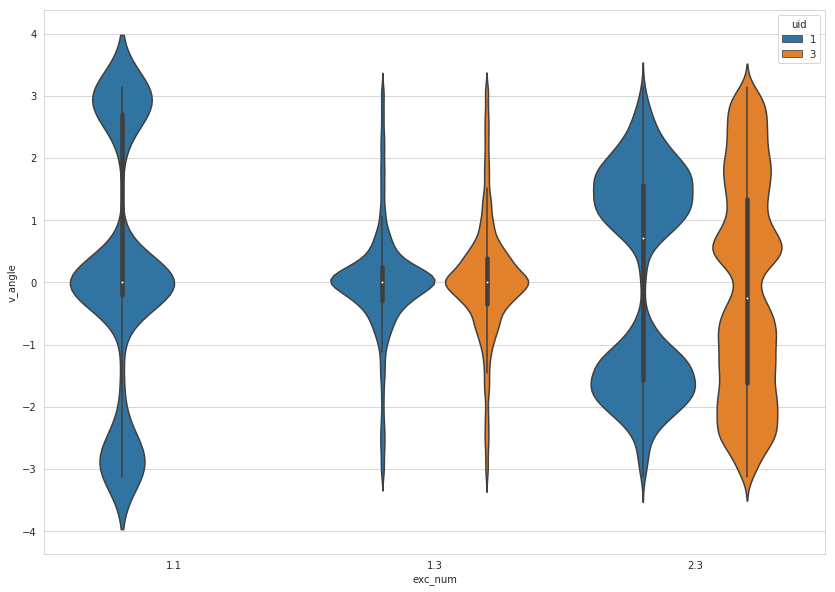

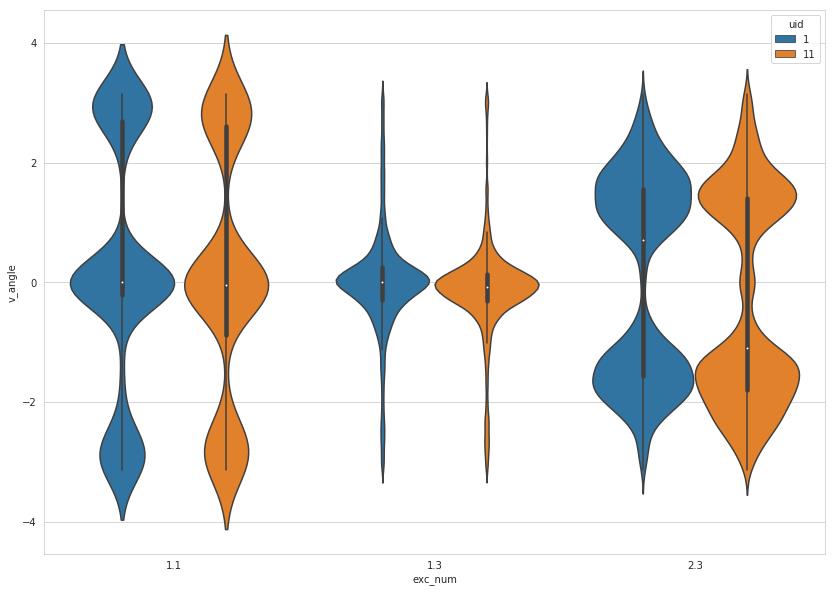

In [35]:
# tmp = all_data[all_data.v_angle>3.1]
tmp = all_data.loc[((all_data.uid==1) | (all_data.uid==3)) & ((all_data.exc_num==1.3) | (all_data.exc_num==2.3) | 
                                                             (all_data.exc_num==1.1))]
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.violinplot(x="exc_num", y='v_angle', hue='uid', data=tmp)

tmp = all_data.loc[((all_data.uid==1) | (all_data.uid==11)) & ((all_data.exc_num==1.3) | (all_data.exc_num==2.3) | 
                                                             (all_data.exc_num==1.1))]
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.violinplot(x="exc_num", y='v_angle', hue='uid', data=tmp)


730


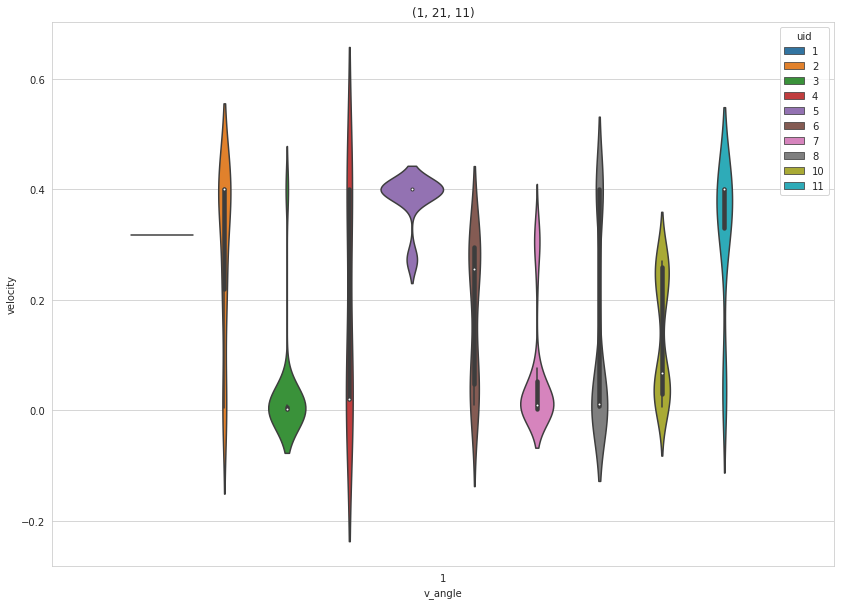

1410


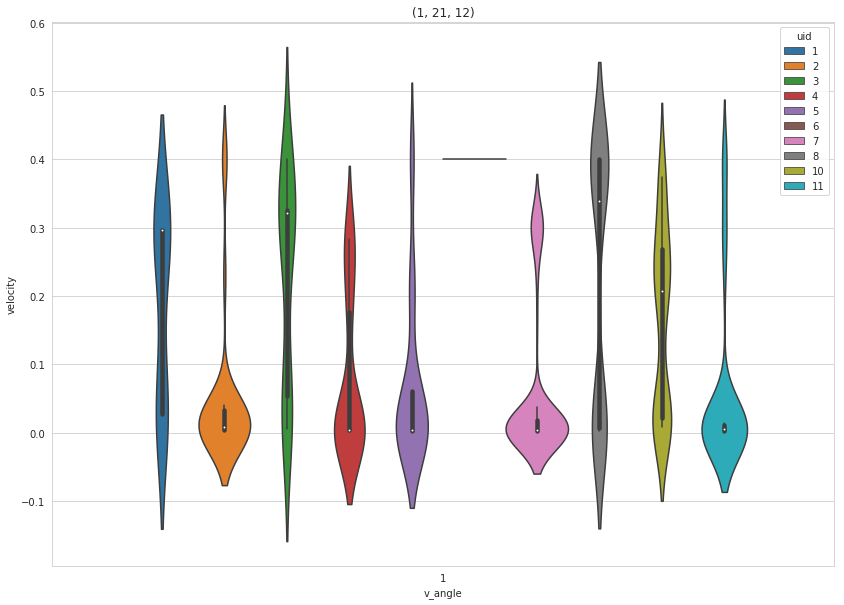

329


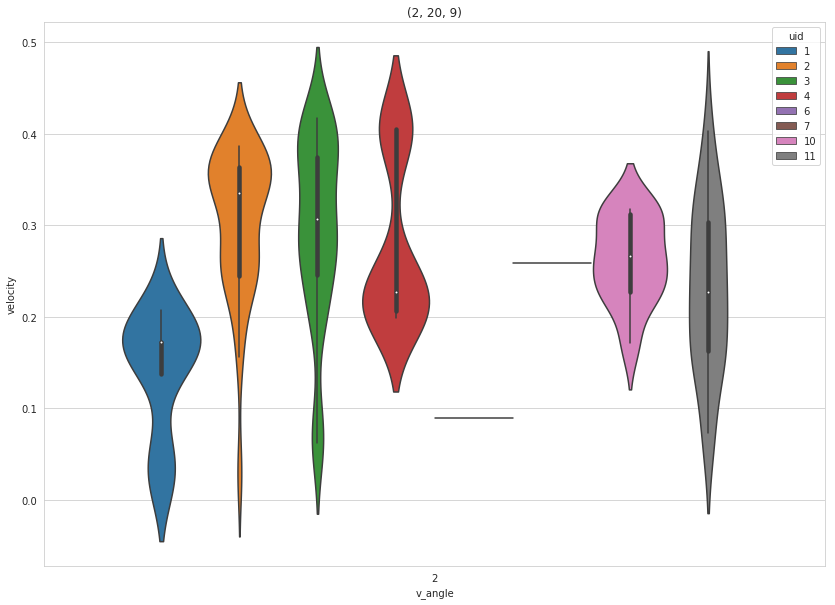

502


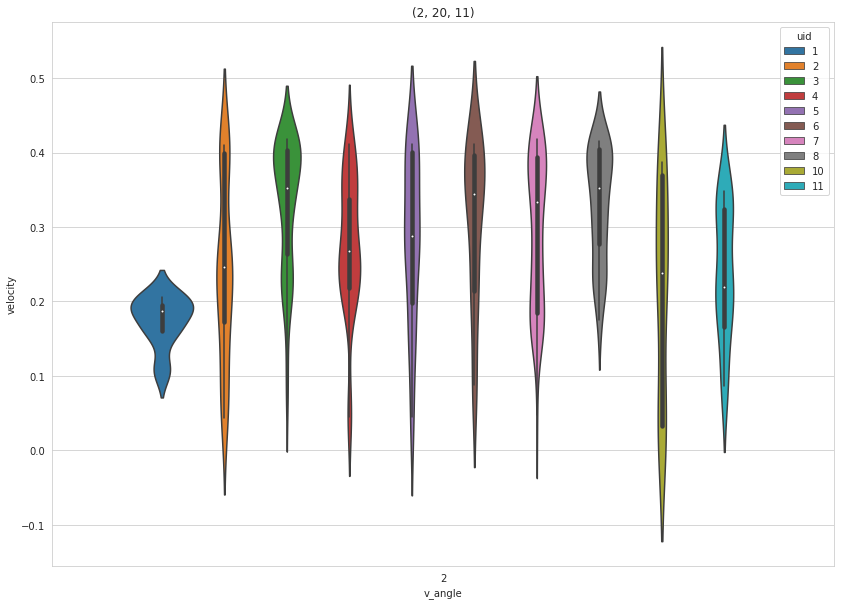

544


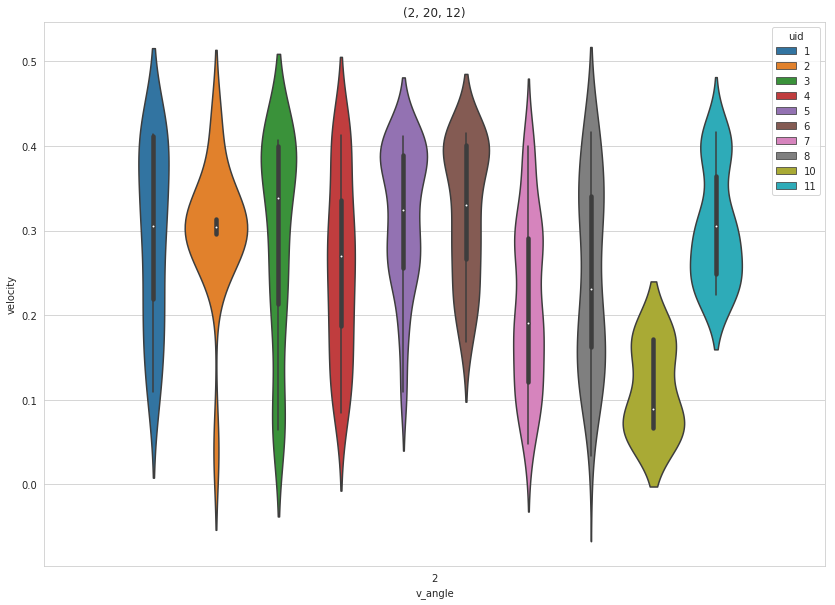

355


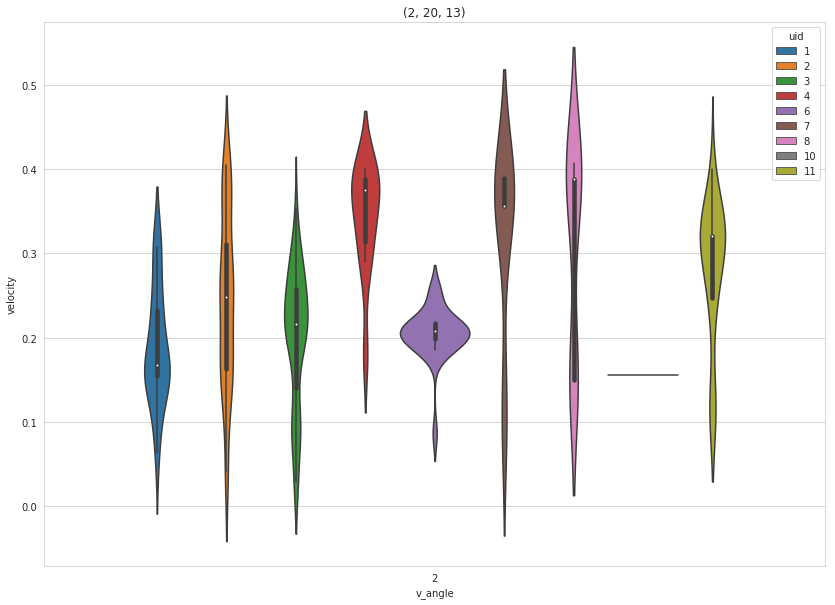

253


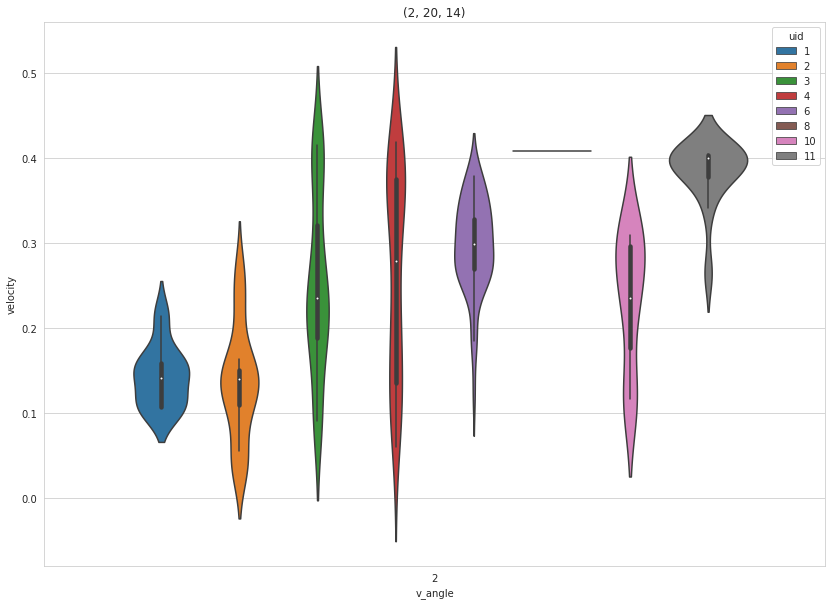

134


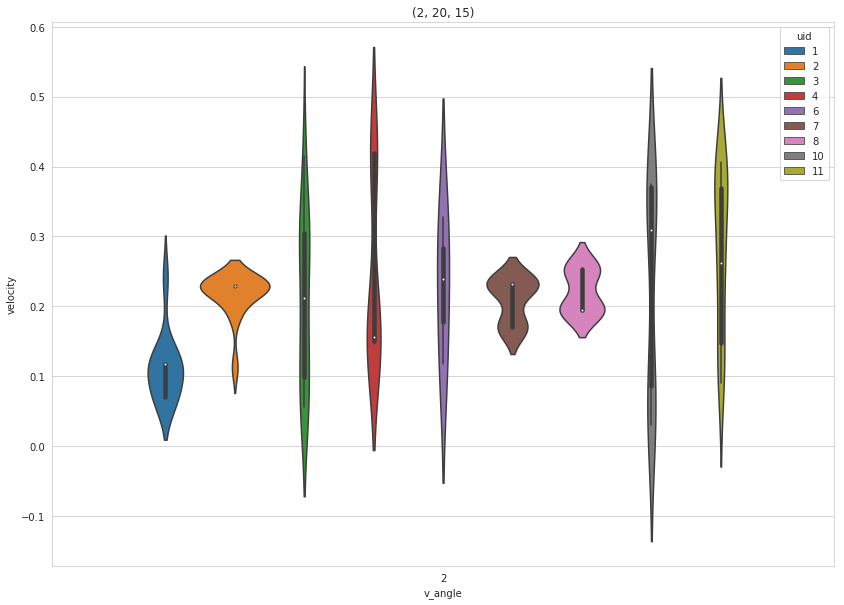

486


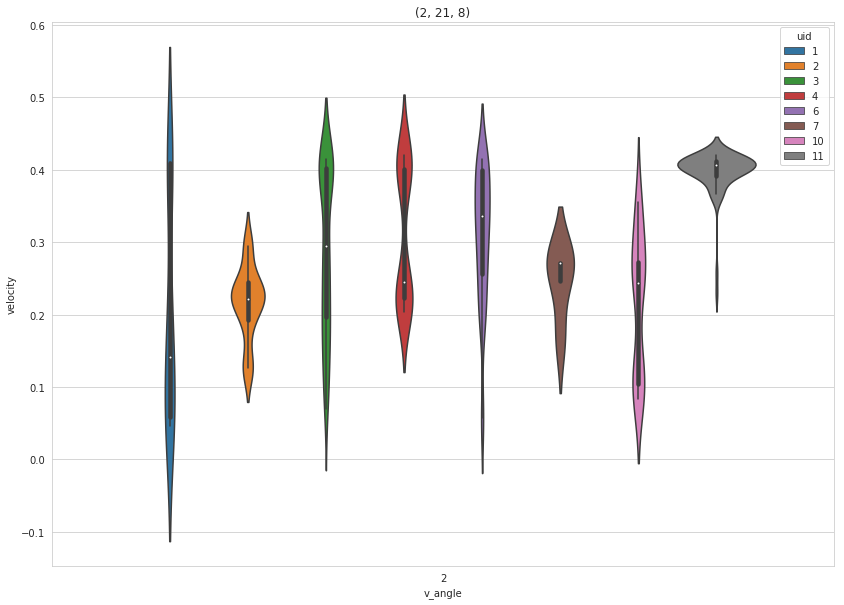

763


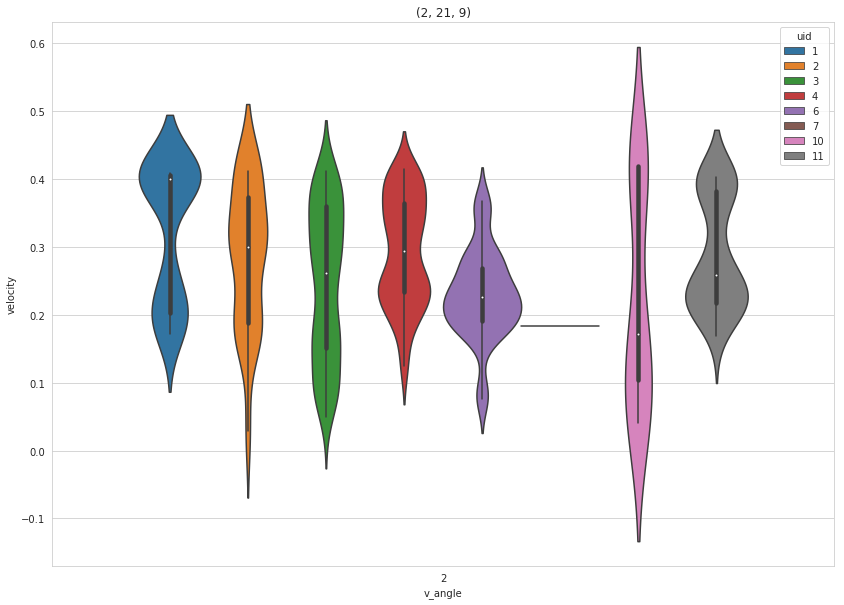

938
6341
9058
1327
959
419
245
450
644
661
496
204
135
146
660
1580
2547
3230
4770
1148
507
341
294
179
626
857
504
221
1280
2843
4573
3002
2338
919
616
496
410
144
262
515
757
423
127
144
676
2047
4424
5086
3421
2549
642
583
581
427
125
111
174
346
495
487
461
130
203
129
845
2369
6143
4821
3572
3333
748
646
657
653
173
298
501
695
702
485
216
187
122
163
1147
2780
5048
4547
4182
4248
930
798
859
727
267
154
121
169
363
541
1103
1112
726
288
270
291
636
1990
3650
4953
5163
6936
1150
1034
1198
839
285
249
234
134
168
741
1747
1760
1405
388
386
434
467
120
677
2107
4203
6356
8727
1725
1544
1965
1277
483
319
271
127
120
196
400
823
1516
2235
2312
657
955
736
563
246
194
722
1665
3384
7397
10496
2749
2892
2989
2211
756
144
139
195
244
417
567
135
149
497
877
1122
1725
3347
4255
1597
1258
1388
875
451
281
895
2052
3692
7226
26295
30113
7100
6511
5030
2581
867
132
214
388
351
148
162
144
372
823
1164
1887
3089
3397
1265
1144
903
505
136
434
1742
2757
4857
7301
24109
27592
6052
4736
2528
120

In [6]:
# del tmp
# tmp = all_data.copy()
tmp = all_data.loc[#((all_data.uid==2) | (all_data.uid==6)) 
                    (all_data.day==2) 
#                    & (all_data.exc_num==1.3) 
#                    & (all_data.exc_times==1)
                  ]
cnt = 0
by_cols = ['v_angle', 'v_sd',
           'torque_xy_avg'
          ]
for index,group in tmp.groupby(by_cols):
    
    if len(group)<100 or len(group['uid'].unique())<8:
        continue
    print(len(group))
    cnt += 1
    if cnt>10: continue
    group = group.reset_index()
    sns.set_style('whitegrid')
    f, ax= plt.subplots(figsize = (14, 10))
    ax = sns.violinplot(x="v_angle", y='velocity', hue='uid', data=group)
    ax.set_title(index)
    plt.show()

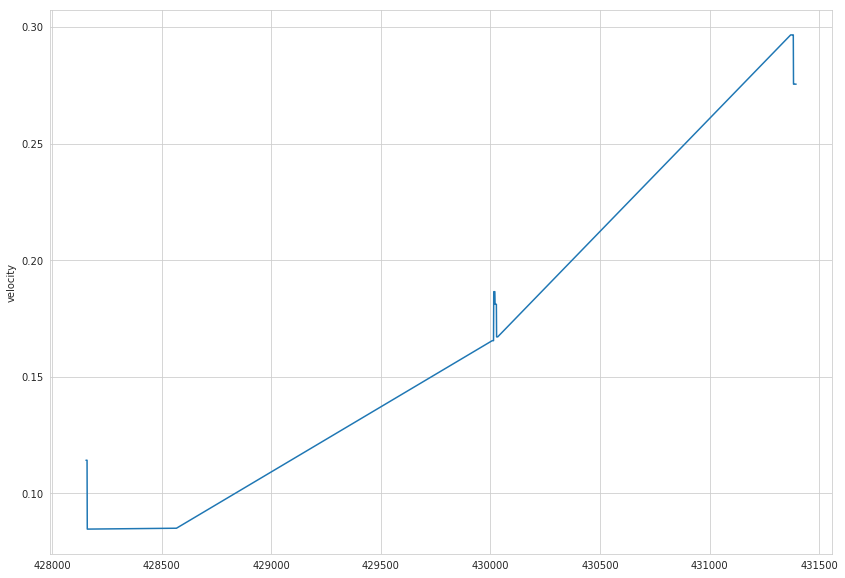

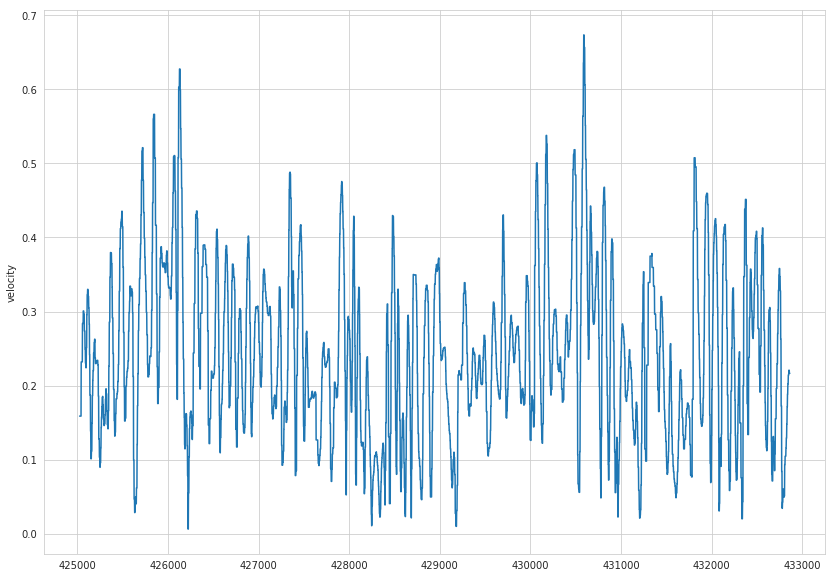

In [50]:
tmp = all_data.loc[((all_data.uid==2)) & (all_data.v_angle==4) & (all_data.v_sd==6) & (all_data.torque_xy==6)
                   & (all_data.day==1) & (all_data.exc_num==1.3) & (all_data.exc_times==1)]
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.lineplot(x=tmp.index, y='velocity', data=tmp)

tmp = all_data.loc[((all_data.uid==2)) 
                   & (all_data.day==1) & (all_data.exc_num==1.3) & (all_data.exc_times==1)]
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.lineplot(x=tmp.index, y='velocity', data=tmp)

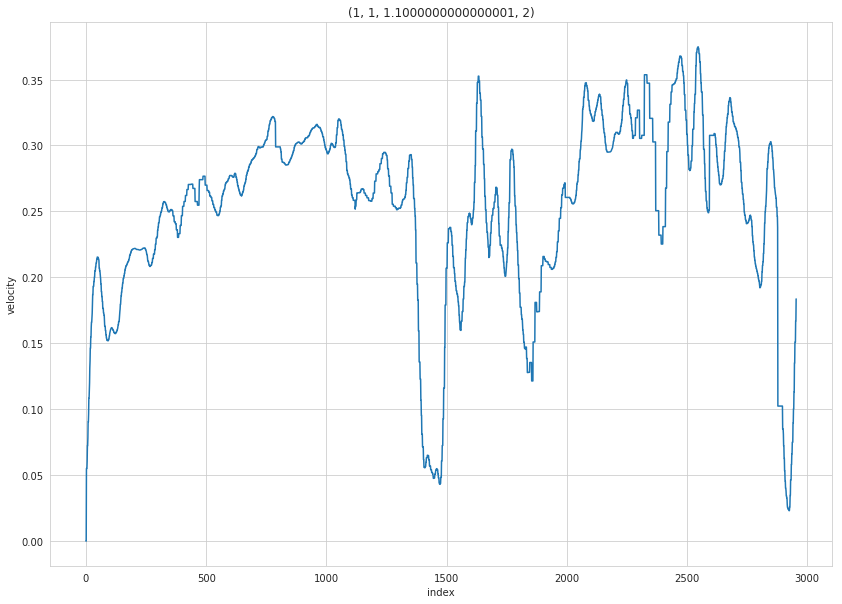

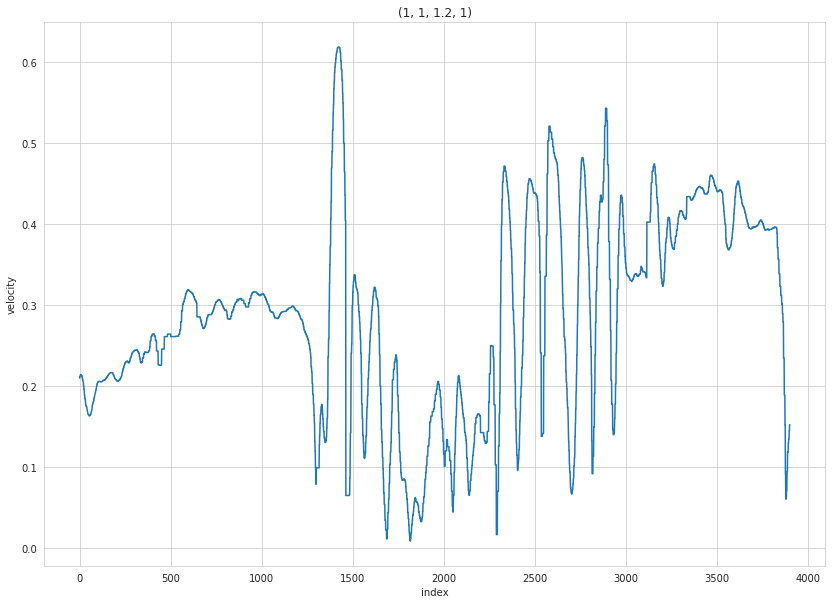

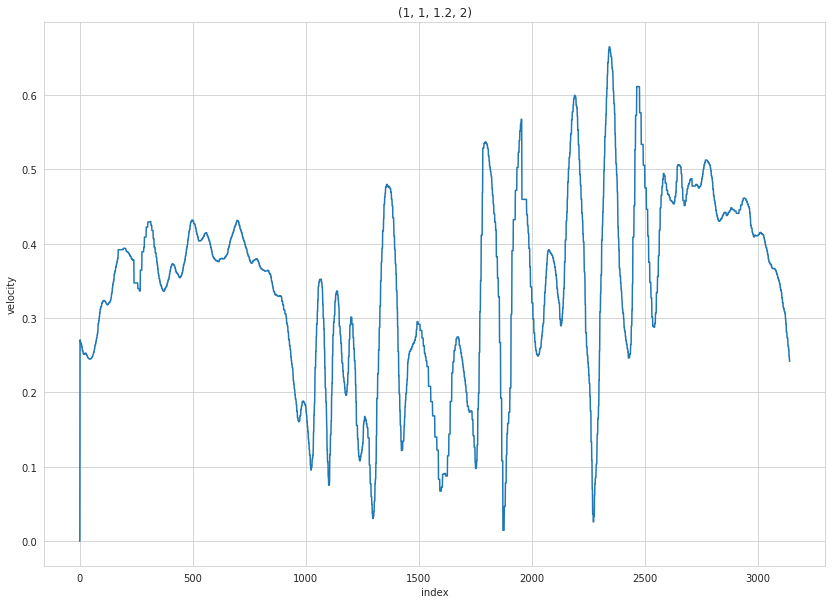

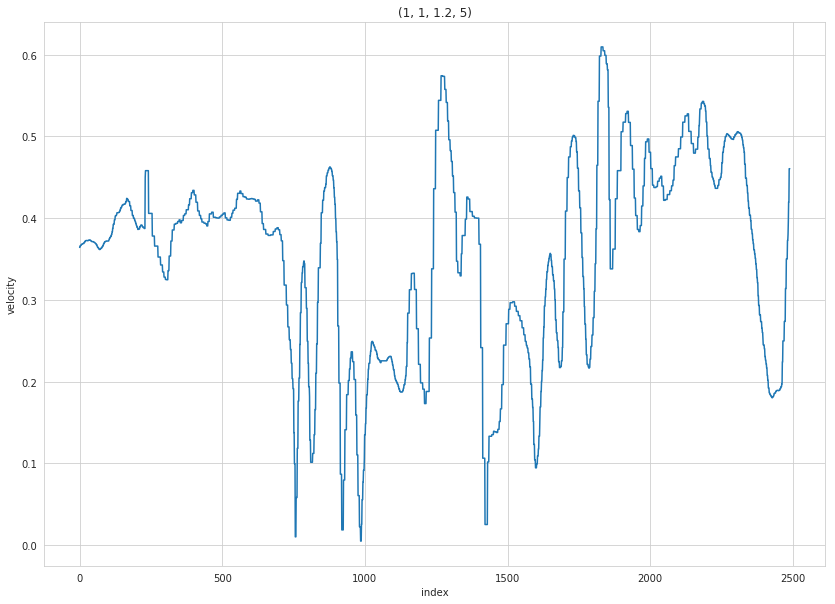

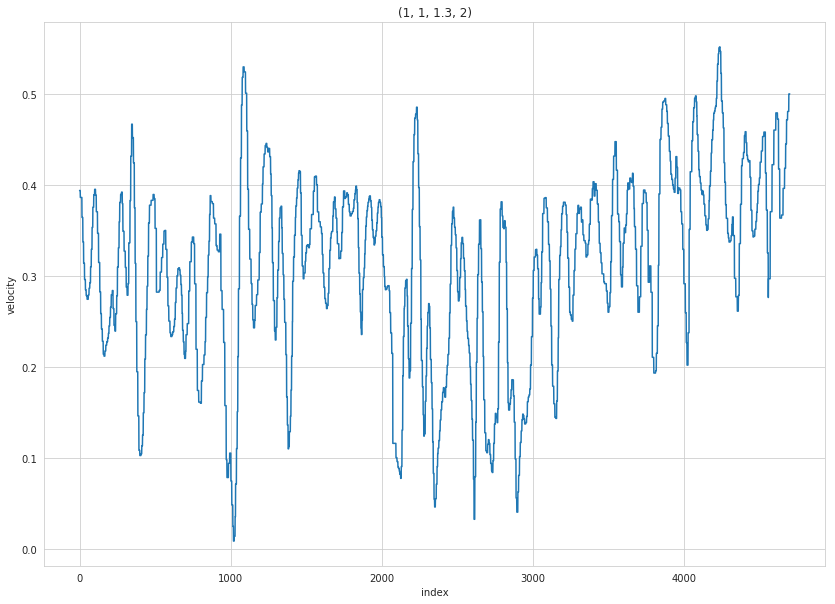

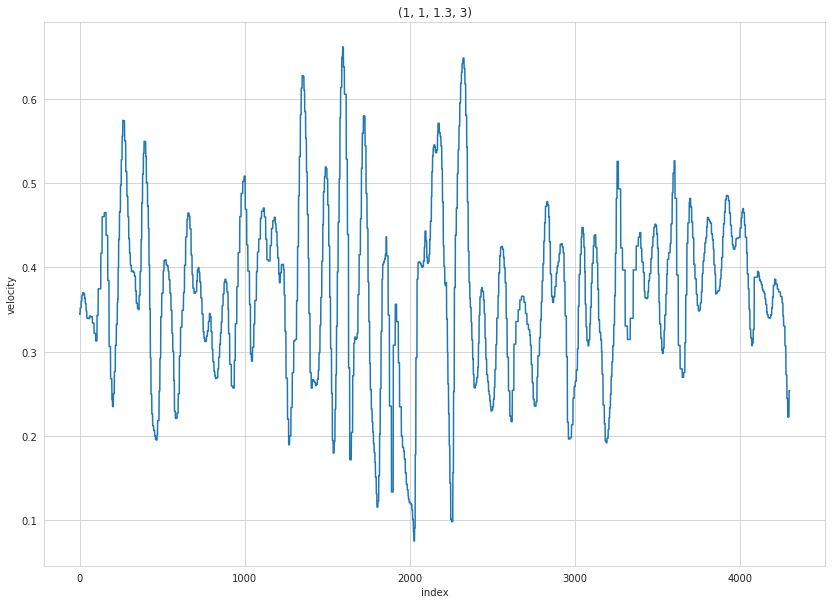

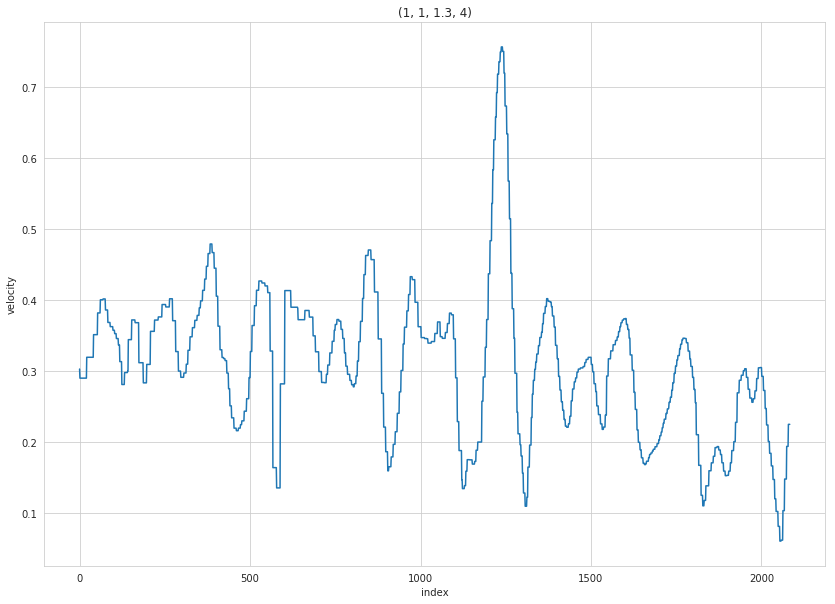

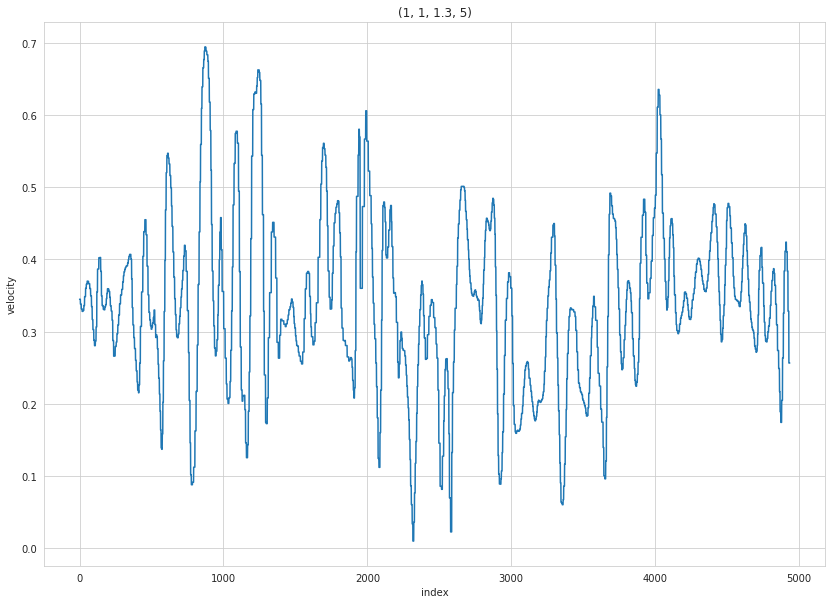

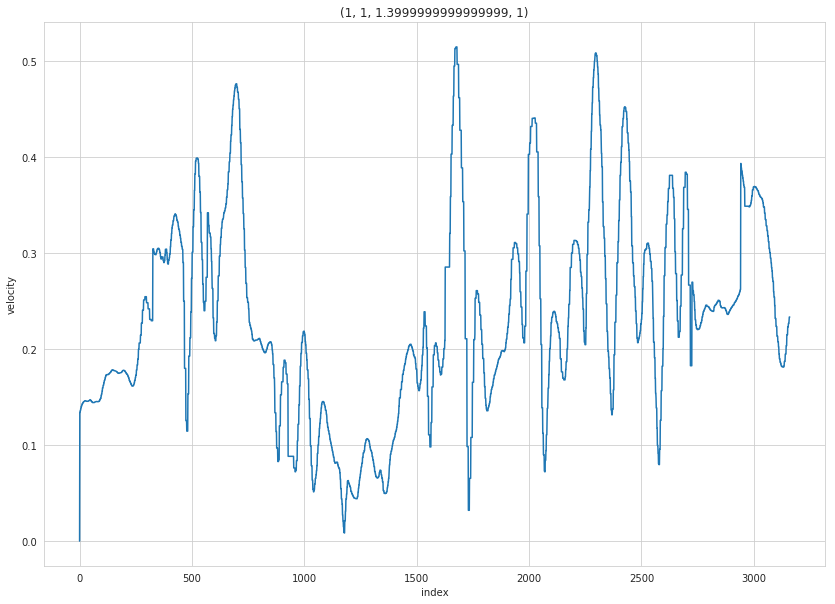

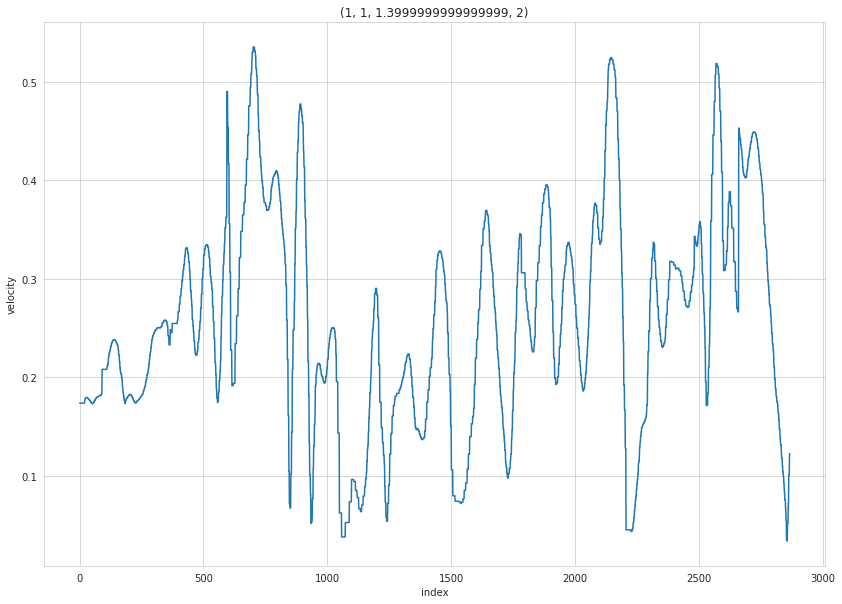

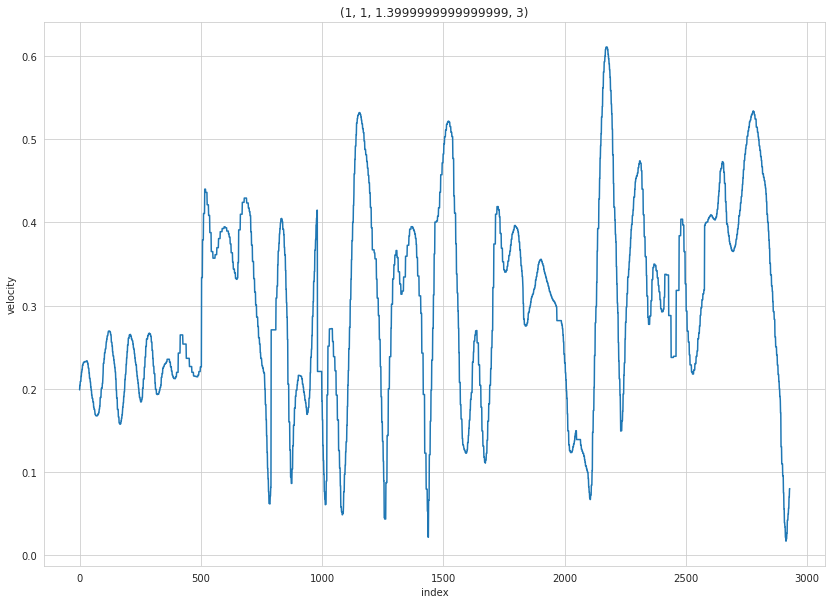

In [9]:
# parameters
target_col = 'velocity'
target_exc = None
cnt = 0


if target_exc is None:
    groups = all_data[['day', 'uid', 'exc_num', 'exc_times', target_col]].groupby(['day', 'uid', 'exc_num', 'exc_times'])
else:
    tmp = all_data[all_data['exc_num']==target_exc]
    assert len(tmp)>10, 'empty data'
    groups = tmp[['day', 'uid', 'exc_num', 'exc_times', target_col]].groupby(['day', 'uid', 'exc_num', 'exc_times'])
    del tmp



for index, group in groups:
    if cnt>10:
        break
    cnt += 1
    
#     print(index)
    tmp = group.reset_index(drop=True)
    tmp = tmp.reset_index()
#     print(group)
    sns.set_style('whitegrid')
    f, ax= plt.subplots(figsize = (14, 10))
    ax = sns.lineplot(x="index", y=target_col, data=tmp)
    ax.set_title(index)

### clear outlier that recorded in file

In [4]:
outliers = []

with open('../data/deviation_curves_outlier.csv') as f:
    for line in f.readlines():
        tmp = line.split('\n')[0].split(' ')
       
        outliers.append([float(x) for x in tmp])
        
groups = all_data.set_index(['day', 'exc_num', 'exc_times', 'uid'])
groups = groups.groupby(by=groups.index)

new_data = pd.DataFrame()

for index, group in groups:
    if len(group)<10:
        print('short length')
        print(index)
        continue
    day, exc_num, exc_times, uid = index
    exc_num = round(exc_num, 1)
    if [day, exc_num, exc_times, uid] in outliers:
        print([day, exc_num, exc_times, uid])
        print('in the outlier list')
        pass
#         tmp = group.reset_index()
#         sns.set_style('whitegrid')
#         f, ax= plt.subplots(figsize = (14, 10))
#         ax = sns.lineplot(x=tmp.index, y="front", data=tmp)
#         ax.set_title(index) 
    else:
        curr = group.reset_index()
        new_data = pd.concat([new_data, curr], axis=0)
        
len(new_data)

short length
(1, 1.1, 3, 3)
short length
(1, 1.1, 3, 10)
short length
(1, 1.2, 1, 3)
short length
(1, 1.2, 1, 8)
short length
(1, 1.2, 1, 10)
short length
(1, 1.2, 1, 11)
short length
(1, 1.2, 2, 3)
short length
(1, 1.2, 2, 8)
short length
(1, 1.2, 2, 10)
short length
(1, 1.2, 2, 11)
short length
(1, 1.2, 3, 3)
short length
(1, 1.2, 3, 8)
[1, 1.2, 3, 10]
in the outlier list
short length
(1, 1.2, 3, 11)
short length
(1, 1.2, 4, 3)
short length
(1, 1.2, 4, 11)
short length
(1, 1.2, 5, 3)
short length
(1, 1.2, 5, 11)
short length
(1, 1.2, 6, 11)
[1, 1.3, 4, 10]
in the outlier list
[1, 1.3, 6, 8]
in the outlier list
[1, 1.4, 2, 3]
in the outlier list
short length
(2, 1.1, 1, 1)
short length
(2, 1.1, 1, 2)
short length
(2, 1.1, 1, 3)
short length
(2, 1.1, 1, 4)
short length
(2, 1.1, 1, 5)
[2, 1.1, 1, 6]
in the outlier list
short length
(2, 1.1, 1, 8)
short length
(2, 1.1, 2, 1)
short length
(2, 1.1, 2, 6)
short length
(2, 1.1, 2, 8)
short length
(2, 1.1, 3, 6)
short length
(2, 1.2, 1, 1)
sh

2979058

### reduce initial deviation

In [5]:
def reduce_header(data, head=500, has_tail=False):
    
    groups = data.set_index(['day', 'exc_num', 'exc_times', 'uid'])
    groups = groups.groupby(groups.index)
    result = pd.DataFrame()
    
    for index, group in groups:
        
        if has_tail:
            assert len(group)>(head*2), 'outlier'
        else:
            assert len(group)>head, 'outlier'
            
        header = [i+1 for i in xrange(head)]
        if has_tail:
            tailer = header[::-1]
            middle = [head for i in xrange(len(group)-head*2)]
            weights = header+middle+tailer

        else:
            middle = [head for i in xrange(len(group)-head)]

            weights = header+middle
            
        weights = pd.Series(weights)    
        weights = weights/head
        assert len(group)==len(weights), 'different length between group and weights'
        curr = group.reset_index()
        curr['front'] =curr['front']*weights
        result = pd.concat([result, curr])
        del curr
        
    return result.reset_index(drop=True)
                            

new_data = reduce_header(new_data,  head=300, has_tail=True)


In [6]:

print(len(new_data))
new_data.head()

2979058


,day,exc_num,exc_times,uid,velocity,force,front,torque_xy,tt_freq,Lx,Ly,Az,Fx,Fy,Fz,Mx,My,Mz
0,1,1.1,1,4,0.021297,18.561272,0.000039,-0.192111,0.0,0.021297,0.0,0.006509,13.101470,8.421651,-10.096936,-0.298042,-0.194137,-0.192111
1,1,1.1,1,4,0.021297,18.561272,0.000078,-0.192111,0.0,0.021297,0.0,0.006509,13.101470,8.421651,-10.096936,-0.298042,-0.194137,-0.192111
2,1,1.1,1,4,0.023768,23.049513,0.000120,-1.395340,1.0,0.023768,0.0,0.005268,17.626004,8.616813,-12.097711,-0.912210,-0.343280,-1.395340
3,1,1.1,1,4,0.023768,23.049513,0.000164,-1.395340,1.0,0.023768,0.0,0.005268,17.626004,8.616813,-12.097711,-0.912210,-0.343280,-1.395340
4,1,1.1,1,4,0.031793,32.181287,0.000206,-2.664103,1.0,0.031793,0.0,0.000000,26.372884,9.167783,-16.001812,-1.404008,-0.658096,-2.664103


In [7]:
new_data.to_csv('../data/step1_clear_data.csv', index=False)

### postprocessing

In [8]:
df = pd.read_csv('../data/step1_clear_data.csv')

In [9]:
def calc_avg_velocity(df, interval=20):
    if 'velocity' not in df.columns:
        df = calc_velocity(df)
        
    df['avg_velocity'] = df['velocity'].rolling(interval, min_periods=1).mean()
    return df

def find_forwards_segment(df, exc=1.1, rotation_threshold=1, new_num=0.1):
    assert exc is not None, 'rewrite function find_forwards_segment first'
    tmp = df[df['exc_num']==exc]
    tmp = tmp.loc[(tmp.Lx>0) & ((tmp.Az<rotation_threshold) | (tmp.Az>-rotation_threshold))]
    tmp['exc_num'] = new_num
    df = pd.concat([df, tmp])
    df = df.reset_index(drop=True)
    del tmp
    return df

In [10]:
df = calc_avg_velocity(df)
df = find_forwards_segment(df)
df

,day,exc_num,exc_times,uid,velocity,force,front,torque_xy,tt_freq,Lx,Ly,Az,Fx,Fy,Fz,Mx,My,Mz,avg_velocity
0,1,1.1,1,4,0.021297,18.561272,0.000039,-0.192111,0.0,0.021297,0.000000,0.006509,13.101470,8.421651,-10.096936,-0.298042,-0.194137,-0.192111,0.021297
1,1,1.1,1,4,0.021297,18.561272,0.000078,-0.192111,0.0,0.021297,0.000000,0.006509,13.101470,8.421651,-10.096936,-0.298042,-0.194137,-0.192111,0.021297
2,1,1.1,1,4,0.023768,23.049513,0.000120,-1.395340,1.0,0.023768,0.000000,0.005268,17.626004,8.616813,-12.097711,-0.912210,-0.343280,-1.395340,0.022121
3,1,1.1,1,4,0.023768,23.049513,0.000164,-1.395340,1.0,0.023768,0.000000,0.005268,17.626004,8.616813,-12.097711,-0.912210,-0.343280,-1.395340,0.022532
4,1,1.1,1,4,0.031793,32.181287,0.000206,-2.664103,1.0,0.031793,0.000000,0.000000,26.372884,9.167783,-16.001812,-1.404008,-0.658096,-2.664103,0.024384
5,1,1.1,1,4,0.031793,32.181287,0.000247,-2.664103,1.0,0.031793,0.000000,0.000000,26.372884,9.167783,-16.001812,-1.404008,-0.658096,-2.664103,0.025619
6,1,1.1,1,4,0.031793,32.181287,0.000307,-2.664103,1.0,0.031793,0.000000,0.000000,26.372884,9.167783,-16.001812,-1.404008,-0.658096,-2.664103,0.026501
7,1,1.1,1,4,0.045657,40.811792,0.000351,-2.824707,1.0,0.045657,0.000000,-0.006518,34.776517,9.842288,-18.955886,-1.519110,-0.826354,-2.824707,0.028896
8,1,1.1,1,4,0.045657,40.811792,0.000395,-2.824707,1.0,0.045657,0.000000,-0.006518,34.776517,9.842288,-18.955886,-1.519110,-0.826354,-2.824707,0.030758
9,1,1.1,1,4,0.045657,40.811792,0.000439,-2.824707,1.0,0.045657,0.000000,-0.006518,34.776517,9.842288,-18.955886,-1.519110,-0.826354,-2.824707,0.032248


In [11]:
df.to_csv('../data/step1_clear_data.csv', index=False)